Script for 'building_heating' program in Python<br>
Licensed under the Apache License, Version 2.0<br>
http://www.apache.org/licenses/LICENSE-2.0

In the first part of the analysis, we construct a schematic representation of the building.

In [1]:
# The magic command "%matplotlib notebook" to make interactive plots within the Jupyter Notebook
# Import numpy library (for arrays operations)
# Import matplotlib.pyplot interface (for MATLAB-like plots)

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Range of coordinates indices x, y, z for the building plot

x, y, z = np.indices((12, 26, 6))

In [3]:
# Definition of the building volumes and colors

ground = (x < 12) & (y < 26) & (z < 1)
floors = (x < 12) & (y < 26) & (1 <= z) & (z < 6)
building = ground | floors
    
building_color = np.empty(building.shape, dtype=object)
building_color[ground] = 'grey'
building_color[floors] = 'white'

In [4]:
# Definition of the 4th floor apartments volumes and colors

apart_41 = (0 <= x) & (x < 12) & (19 <= y) & (y < 26) & (3 <= z) & (z < 4)
apart_42 = (8 <= x) & (x < 12) & (10 <= y) & (y < 19) & (3 <= z) & (z < 4)
apart_43 = (6 <= x) & (x < 12) & (0 <= y) & (y < 8) & (3 <= z) & (z < 4)
apart_44 = (0 <= x) & (x < 6) & (0 <= y) & (y < 10) & (3 <= z) & (z < 4)
apart_45 = (0 <= x) & (x < 6) & (10 <= y) & (y < 17) & (3 <= z) & (z < 4)
apartments = apart_41 | apart_42 | apart_43 | apart_44 | apart_45

apartments_color = np.empty(building.shape, dtype=object)
apartments_color[apart_41] = 'gold'
apartments_color[apart_42] = 'red'
apartments_color[apart_43] = 'blue'
apartments_color[apart_44] = 'violet'
apartments_color[apart_45] = 'green'

<IPython.core.display.Javascript object>


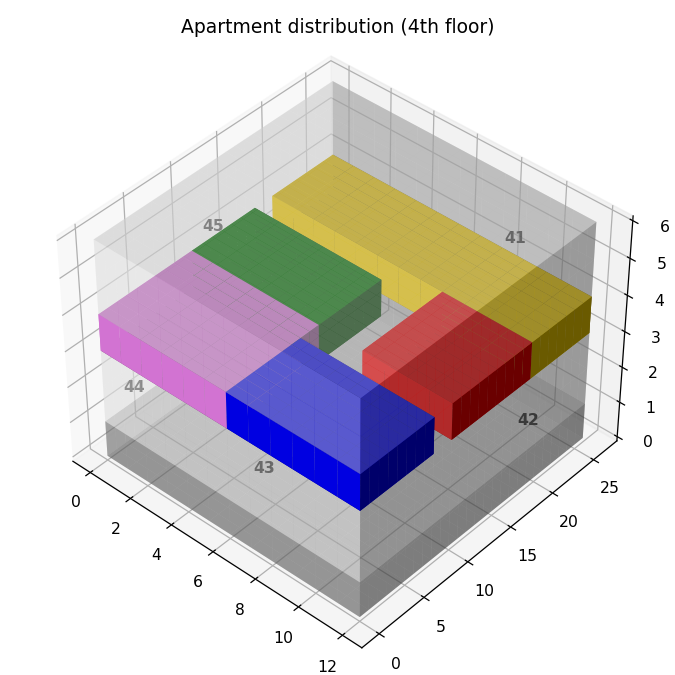

In [5]:
# Interactive 3D plot of the building

# Parameters, title and text of the 3D plot

ax = plt.figure(figsize=(6, 6)).add_subplot(projection='3d')
ax.voxels(building, facecolors=building_color, alpha=0.4)
ax.voxels(apartments, facecolors=apartments_color)

plt.title('Apartment distribution (4th floor)')

ax.text(8.5, -3, 3.3, '43', weight='bold')
ax.text(2.5, -3, 3.3, '44', weight='bold')
ax.text(7, 29, 3.3, '41', weight='bold')
ax.text(13.5, 13.5, 3.3, '42', weight='bold')
ax.text(-1.5, 14.5, 3.3, '45', weight='bold')

plt.tight_layout()

In the next part, we use Python librarires to set up the connection to the MySQL database containing the data of the building.

In [6]:
# Import os module (for interacting with the operating system)
# Import pandas library (for data analysis in Python)
# Import create_engine from the sqlalchemy toolkit (standard SQL toolkit in Python)
# Import load_dotenv from the dotenv module (for setting environment variables)

import os
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv

In [7]:
# Load from a (hidden) .env file the MySQL credentials of the mysql database of the building

load_dotenv()
user = os.getenv('MySQL_USER')
passwd = os.getenv('MySQL_PASSWORD')
host = os.getenv('MySQL_HOST')
port = os.getenv('MySQL_PORT')
db = os.getenv('MySQL_DB')

In [8]:
# Create a connection ("engine") to the MySQL database using the credentials

engine = create_engine('mysql://%s:%s@%s:%s/%s' % (user, passwd, host, port, db))

The analysis involves 3 tables from the database, "Apartments", "Power" and "Temperatures", that we now describe.

The Apartments table contains the list of all units of the building (31 apartments + 4 weather stations). The "esmart_id" is the identification number given to each unit by the firm eSMART. The column "name" is a more intuitive identification number for the units. For instance, the name "43" corresponds to floor 4, apartment 3.

In [9]:
# Read the Apartments table into a DataFrame "df_apart"

df_apart = pd.read_sql('SELECT * FROM Apartments', engine)
df_apart

,esmart_id,name
0,1046,11
1,1047,12
2,1048,13
3,1049,14
4,1050,15
5,1041,21
6,1042,22
7,1043,23
8,1044,24
9,1045,25


The Power table contains information about power consumption of each unit starting from the date 2017-10-12. Each row of the table contains the "apartment_id" (= esmart_id), the "module_id" of the module taking the measure, namely,

- <b>17</b> for electric power measured in Watt [W],
- <b>18</b> for the energy measured in Watt-hour [W⋅h]

the "date" of the measure and the "value" measured by the module.

In [10]:
# Read the first 100 rows of Power table into a DataFrame "df_power"

df_power = pd.read_sql('SELECT * FROM Power LIMIT 100', engine)
df_power

,apartment_id,module_id,date,value
0,1026,17,2017-10-12,9242
1,1026,17,2017-10-13,10658
2,1026,17,2017-10-14,11523
3,1026,17,2017-10-15,12394
4,1026,17,2017-10-16,13260
...,...,...,...,...
95,1026,17,2018-01-15,387485
96,1026,17,2018-01-16,392215
97,1026,17,2018-01-17,396945
98,1026,17,2018-01-18,401808


The Temperatures table contains information about temperatures in each unit starting from the date 2021-03-15. Each row of the table contains the "apartment_id", the "module_id" for the room location within the unit of the module taking the measure, namely,

- <b>26</b> for the living room,
- <b>25</b> for dormitory 1,
- <b>1</b> for dormitory 2,
- <b>2</b> for dormitory 3,
- <b>37</b> for dormitory 4,
- <b>38</b> for dormitory 5,
- <b>53</b> for bathroom 1,
- <b>54</b> for bathroom 2,

the "date" of the measure, the "action" of the module (<b>get</b> for the temperature measured in the room and <b>set</b> for the temperature set in the room) and the "value" for the temperature.

In [158]:
# Read the first 100 rows of Temperatures table into a DataFrame "df_temp"

df_temp = pd.read_sql('SELECT * FROM Temperatures WHERE action="get" LIMIT 100', engine)
df_temp

,apartment_id,module_id,date,action,value
0,1026,13,2021-03-15 11:46:52,get,21.81
1,1026,13,2021-03-15 12:03:51,get,21.81
2,1026,13,2021-03-15 12:07:15,get,21.81
3,1026,13,2021-03-15 12:17:26,get,21.81
4,1026,13,2021-03-15 12:34:25,get,21.81
...,...,...,...,...,...
95,1026,13,2021-03-16 03:37:39,get,22.31
96,1026,13,2021-03-16 03:47:52,get,22.31
97,1026,13,2021-03-16 03:58:01,get,22.31
98,1026,13,2021-03-16 04:15:00,get,22.31


In this part of the analysis, we retrieve and plot in pie chart the data of energy consumption of each unit of the building, over any prescribed period of time defined by a "start_date" and an "end_date".

In [12]:
# Set start_date and end_date for the DataFrame of energy consumption

start_date = '"2021-01-01"'
end_date = '"2021-12-31"'

# Read, for each unit of the building, the first energy after the start date into a DataFrame "df_start"

df_start = pd.read_sql('SELECT Apartments.name, Power.date AS initial_date, Power.value AS initial_energy \
                   FROM Power INNER JOIN Apartments ON Power.apartment_id=Apartments.esmart_id \
                   WHERE Power.module_id=18 AND Power.date>=%s \
                   GROUP BY Apartments.name' % start_date, engine)

# Read, for each unit of the building, the last energy before the end date into a DataFrame "df_end"

df_end = pd.read_sql('SELECT Apartments.name, Power.date AS final_date, Power.value AS final_energy \
                   FROM Power INNER JOIN Apartments ON Power.apartment_id=Apartments.esmart_id \
                   WHERE Power.module_id=18 AND Power.date<=%s \
                   ORDER BY Power.date DESC LIMIT 31' % end_date, engine)

# Merging 'df_start' and 'df_end' into a DataFrame 'df_energy' (using 'name' as key)
# (in 2018 there are missing measures; the first measure for unit "O2" is at initial_date "2018-10-10")

df_energy = pd.merge(df_start, df_end, how='left', on='name')
df_energy

,name,initial_date,initial_energy,final_date,final_energy
0,11,2021-01-01,8888000,2021-12-31,10062000
1,12,2021-01-01,7247000,2021-12-31,9054000
2,13,2021-01-01,9461000,2021-12-31,11221000
3,14,2021-01-01,8074000,2021-12-31,11618000
4,15,2021-01-01,8816000,2021-12-31,10676000
5,21,2021-01-01,6902000,2021-12-31,8532000
6,22,2021-01-01,9841000,2021-12-31,11871000
7,23,2021-01-01,2136000,2021-12-31,2604000
8,24,2021-01-01,2503000,2021-12-31,3147000
9,25,2021-01-01,2842000,2021-12-31,3543000


<IPython.core.display.Javascript object>


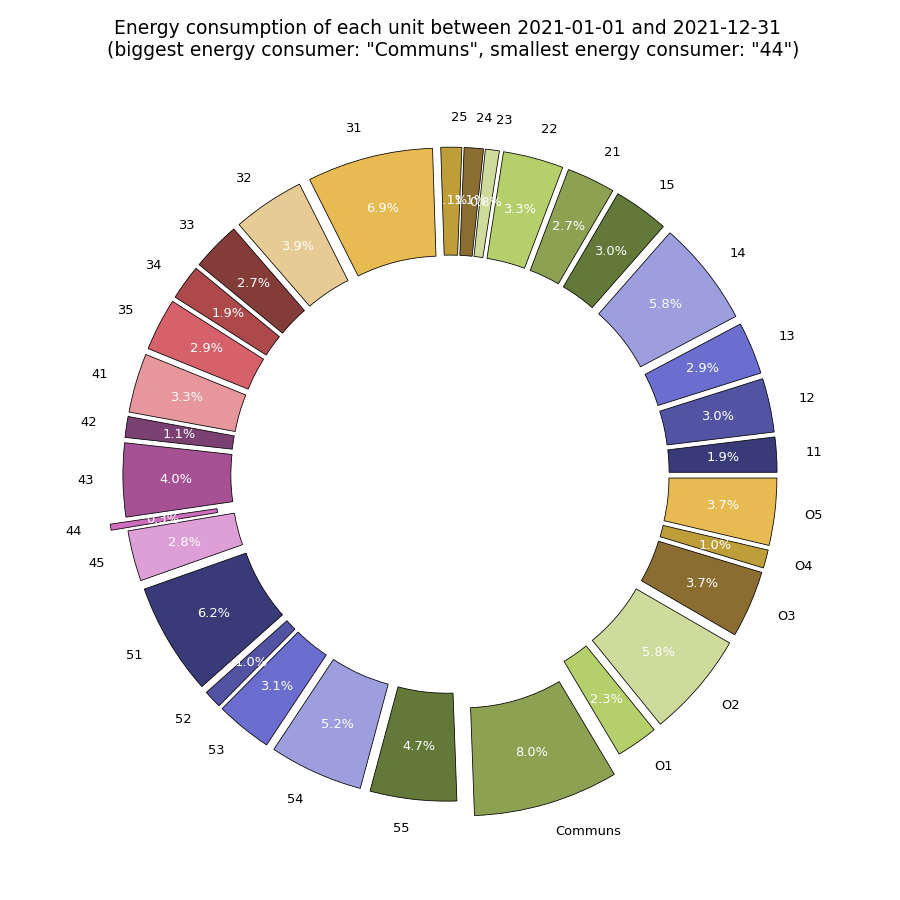

In [71]:
# Pie chart plot of the energy consumption in the building

# Set in a "units" list the names of the pie chart wedges
# Set in a "data" list the differences between final_energy and initial_energy
# Set in a "scales" list the scales of the pie chart wedges
# Set in a "wedges" dictionary the properties of the pie chart wedges
# Set in a "colors" list the colors of the pie chart wedges
# See https://matplotlib.org/stable/tutorials/colors/colormaps.html for details

units = (df_energy['name']).tolist()
data = (df_energy['final_energy']-df_energy['initial_energy']).tolist()
scales = [0.15 if data[i] == max(data) or data[i] == min(data) else 0.1 for i in range(len(data))]
wedges = {'width':0.33, 'edgecolor':'black', 'linewidth':0.5}
colors = plt.colormaps['tab20b'](range(20))

# Parameters and title of the pie chart plot

_, ax = plt.subplots(figsize=(8, 8))
_, _, pcts = ax.pie(data, labels=units, explode=scales, radius=0.9, autopct='%.1f%%', colors=colors,
                    wedgeprops=wedges, pctdistance=0.82, textprops={'size': 'small'})
ax.set_title('Energy consumption of each unit between %s and %s \n \
(biggest energy consumer: \"%s\", smallest energy consumer: \"%s\")'
             % (eval(start_date), eval(end_date), units[data.index(max(data))], units[data.index(min(data))]))
plt.setp(pcts, color='w')

plt.tight_layout()

In [190]:
initial_date = '"2021-03-15"'
final_date = '"2022-12-31"'

dflist_get, dflist_set = [], []

for unit in units:
    temp_get = pd.read_sql('SELECT DATE(Temperatures.date) AS date, ROUND(AVG(Temperatures.value),2) AS \'unit %s (get)\' \
                       FROM Temperatures INNER JOIN Apartments ON Temperatures.apartment_id=Apartments.esmart_id \
                       WHERE Apartments.name=\'%s\' AND Temperatures.action="get" \
                       AND Temperatures.date>=%s AND Temperatures.date<=%s \
                       AND TIME(Temperatures.date) BETWEEN "00:00:00" AND "23:59:59" \
                       GROUP BY DATE(Temperatures.date)' % (unit, unit, initial_date, final_date), engine)
    
    temp_set = pd.read_sql('SELECT DATE(Temperatures.date) AS date, ROUND(AVG(Temperatures.value),2) AS \'unit %s (set)\' \
                       FROM Temperatures INNER JOIN Apartments ON Temperatures.apartment_id=Apartments.esmart_id \
                       WHERE Apartments.name=\'%s\' AND Temperatures.action="set" \
                       AND Temperatures.date>=%s AND Temperatures.date<=%s \
                       AND TIME(Temperatures.date) BETWEEN "00:00:00" AND "23:59:59" \
                       GROUP BY DATE(Temperatures.date)' % (unit, unit, initial_date, final_date), engine)
    
    dflist_get.append(temp_get)
    dflist_set.append(temp_set)

In [364]:
from functools import reduce

merge_get = reduce(lambda x, y: pd.merge(round(x,2), round(y,2), on='date', how='outer'), dflist_get)
df_get = merge_get.copy(deep=True)

df_get['median (get)'] = round((merge_get.drop('date', axis=1)).median(axis=1),2)
df_get['min (get)'] = round((merge_get.drop('date', axis=1)).min(axis=1),2)
df_get['max (get)'] = round((merge_get.drop('date', axis=1)).max(axis=1),2)

merge_set = reduce(lambda x, y: pd.merge(round(x,2), round(y,2), on='date', how='outer'), dflist_set)
df_set = merge_set.copy(deep=True)

df_set['median (set)'] = round((merge_set.drop('date', axis=1)).median(axis=1),2)
df_set['min (set)'] = round((merge_set.drop('date', axis=1)).min(axis=1),2)
df_set['max (set)'] = round((merge_set.drop('date', axis=1)).max(axis=1),2)
df_set

,date,unit 11 (set),unit 12 (set),unit 13 (set),unit 14 (set),unit 15 (set),unit 21 (set),unit 22 (set),unit 23 (set),unit 24 (set),...,unit 55 (set),unit Communs (set),unit O1 (set),unit O2 (set),unit O3 (set),unit O4 (set),unit O5 (set),median (set),min (set),max (set)
0,2021-03-15,18.87,20.00,19.50,22.00,22.7,20.83,25.0,20.75,20.34,...,21.66,20.25,20.58,21.25,20.25,20.17,24.00,20.75,18.5,25.0
1,2021-03-16,19.04,20.00,19.46,22.00,NaN,20.83,25.0,20.74,20.33,...,21.67,20.25,20.75,21.25,20.25,20.17,24.00,20.74,18.5,25.0
2,2021-03-17,19.50,20.00,19.25,22.00,NaN,20.83,25.0,20.75,20.33,...,21.67,20.25,20.80,21.25,20.25,20.17,24.00,20.75,18.5,25.0
3,2021-03-18,19.50,20.00,19.25,22.00,NaN,20.83,25.0,20.75,20.33,...,21.67,20.25,20.87,21.25,20.25,20.17,24.00,20.75,18.5,25.0
4,2021-03-19,19.50,20.00,19.25,22.00,NaN,20.83,25.0,20.75,20.34,...,21.67,20.25,20.87,21.25,20.25,20.17,24.11,20.68,18.5,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,2022-04-08,19.62,21.67,20.00,21.83,22.0,19.50,18.0,19.50,20.34,...,21.50,20.25,19.91,23.75,21.00,21.00,24.00,20.34,18.0,24.0
317,2022-04-09,19.62,21.67,20.74,21.83,22.0,19.50,18.0,19.50,20.33,...,21.50,20.25,19.75,23.75,21.00,21.00,24.00,20.67,18.0,24.0
318,2022-04-10,19.62,21.67,22.25,21.83,22.0,19.50,18.0,19.50,20.08,...,21.50,20.25,19.75,23.75,21.00,21.00,24.00,20.67,18.0,24.0
319,2022-04-11,19.63,21.67,22.25,21.83,22.0,19.50,18.0,19.50,19.84,...,21.50,20.25,19.75,23.75,21.00,21.00,24.00,20.67,18.0,24.0


<IPython.core.display.Javascript object>


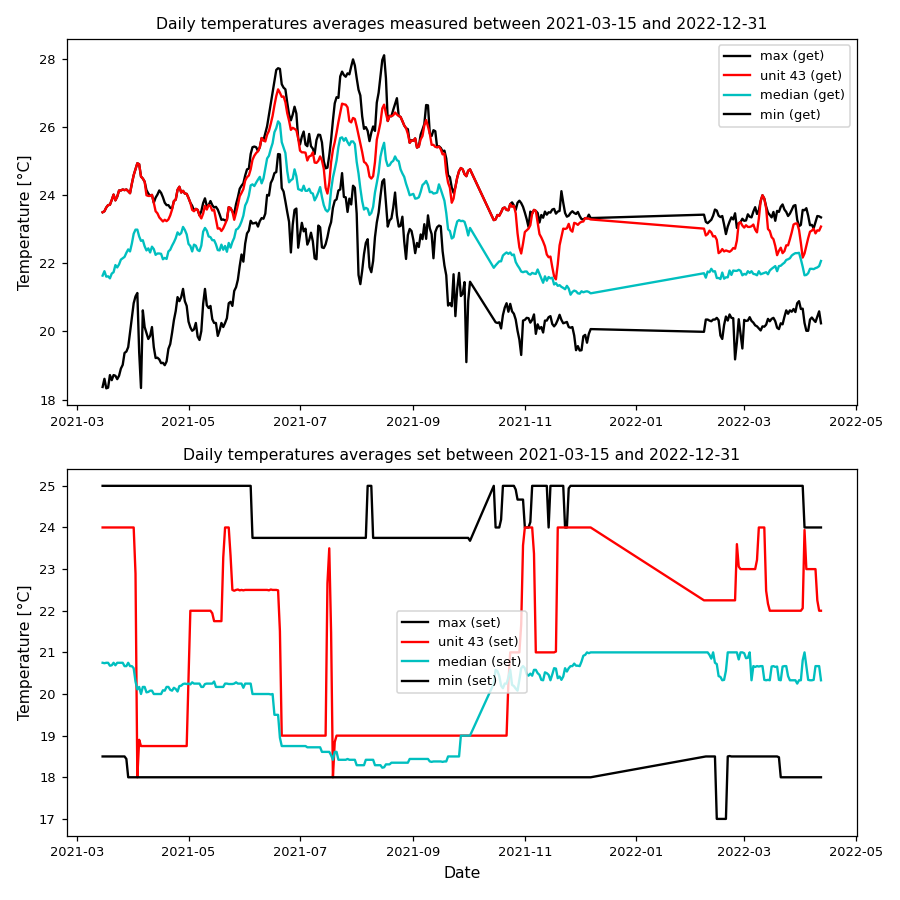

In [365]:
unit = '43'

_, (ax1, ax2) = plt.subplots(2, figsize=(8, 8))

ax1.plot(df_get['date'], df_get['max (get)'], color='k', label='max (get)')
ax1.plot(df_get['date'], df_get['unit %s (get)'% unit], color='r', label='unit %s (get)' % unit)
ax1.plot(df_get['date'], df_get['median (get)'], color='c', label='median (get)')
ax1.plot(df_get['date'], df_get['min (get)'], color='k', label='min (get)')

ax1.set_title('Daily temperatures averages measured between %s and %s'
              % (eval(initial_date), eval(final_date)), size='medium')

ax1.legend(fontsize='small',)
ax1.set_ylabel('Temperature [°C]')

ax2.plot(df_set['date'], df_set['max (set)'], color='k', label='max (set)')
ax2.plot(df_set['date'], df_set['unit %s (set)'% unit], color='r', label='unit %s (set)' % unit)
ax2.plot(df_set['date'], df_set['median (set)'], color='c', label='median (set)')
ax2.plot(df_set['date'], df_set['min (set)'], color='k', label='min (set)')

ax2.set_title('Daily temperatures averages set between %s and %s'
              % (eval(initial_date), eval(final_date)), size='medium')

ax2.legend(fontsize='small')
ax2.set_xlabel('Date')
ax2.set_ylabel('Temperature [°C]')

plt.rcParams['xtick.labelsize'] = 'small'
plt.rcParams['ytick.labelsize'] = 'small'

plt.tight_layout()